In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def load_datasets(year, month, start_day, start_hour=0, end_day=None, end_hour=23):
    """
    Load datasets for specified start day, month, and year.
    
    Parameters:
        year (int): The year of the data.
        month (int): The month of the data.
        start_day (int): The start day of the data.
        start_hour (int, optional): The hour of the start day. Defaults to 0.
        end_day (int, optional): The end day of the data. Defaults to start_day.
        end_hour (int, optional): The hour of the end day. Defaults to 23.
        
    Returns:
        tuple: Xarray Datasets for pressure level and surface datasets.
    """
    
    # Set end_day to start_day if not provided
    if end_day is None:
        end_day = start_day
    
    # Get the last day of the month
    last_day_of_month = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
    last_day_str = f"{last_day_of_month.day:02d}"  # format last day as two digits

    # Format date and time strings
    year_month = f'{year}{month:02d}'
    start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
    end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

    # Define URLs for pressure level datasets with specific time ranges
    urls = {
        'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
        'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
        'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
        'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
        'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
        'w_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_135_w.ll025sc.{start_time}_{end_time}.nc',
        'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc',
        
        # Define URLs for surface datasets to cover the full month using last_day_of_month
        'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'temperature_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_167_2t.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'dew_point_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_168_2d.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc'
    }

    # Initialize empty dictionaries for datasets
    datasets = {}

    # Try to load datasets from the URLs
    for var, url in urls.items():
        try:
            tds_catalog = TDSCatalog(url)
            ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
            ds = xr.open_dataset(ds_url).metpy.parse_cf()
            datasets[var] = ds
            print(f"Successfully loaded {var}")

        except Exception as e:
            print(f"Error loading {var}: {e}")

    # Merge pressure level datasets if available
    ds_pl, ds_sfc = None, None

    try:
        ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], 
                        datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['w_wind_pl'], datasets['pv_pl']])
        print("Successfully merged pressure level datasets")
    except KeyError as e:
        print(f"Error merging pressure level datasets: {e}")

    # Merge surface datasets if available
    try:
        ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc'],
                        datasets['temperature_sfc'], datasets['dew_point_sfc']])
        print("Successfully merged surface datasets")
    except KeyError as e:
        print(f"Error merging surface datasets: {e}")

    # Synchronize time dimensions
    try:
        if ds_pl is not None and ds_sfc is not None:
            first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values
            ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))
    except KeyError as e:
        print(f"Error accessing 'time' in the datasets: {e}")
    except Exception as e:
        print(f"An error occurred during slicing: {e}")
        
    return ds_pl, ds_sfc

In [4]:
variable_name = 'fgen_cross_diagonal'
year = 2019
month = 2
first_day = 13
last_day = first_day
directions = {'North': 55, 
            'East': 250, 
            'South': 20, 
            'West': 200} # units: degrees North, degrees East
start_point = (30, 360 - 134) # units: degrees North, degrees East
end_point = (36, 360 - 127) # units: degrees North, degrees East
g = 9.81 # units: m/s^2


In [8]:
ds_pl, ds_sfc = load_datasets(year=year, month=month, start_day=first_day, end_day=last_day, start_hour=0, end_hour=23)

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded w_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded dew_point_sfc
Successfully merged pressure level datasets
Successfully merged surface datasets


In [21]:
ds_sliced = ds_pl.isel(time=0)
ds_sfc_sliced = ds_sfc.isel(time=0)

# Slice the dataset to get the data for the region of interest
ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

# Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
u_sliced = ds_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
v_sliced = ds_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
q_sliced = ds_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg
t_sliced = ds_sliced['T'].sel(level=slice(500, 1000))

mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

# Flip the order of the pressure levels and convert them to Pa from hPa
pressure_levels = u_sliced.level[::-1].metpy.convert_units('hPa')  # units: hPa

# Calculate dewpoint and theta-e
td = mpcalc.dewpoint_from_specific_humidity(pressure_levels * units.hPa, t_sliced, q_sliced)
theta_e = mpcalc.equivalent_potential_temperature(pressure_levels * units.hPa, t_sliced, t_sliced) # units: K

theta_e_925 = theta_e.sel(level=925)

In [22]:
# Extract latitude and longitude arrays from the dataset
latitudes = theta_e_925['latitude'].values * units.degrees
longitudes = theta_e_925['longitude'].values * units.degrees

# Compute the gradient of theta_e_925
dtheta_e_dy, dtheta_e_dx = mpcalc.gradient(theta_e_925, coordinates=(latitudes, longitudes))

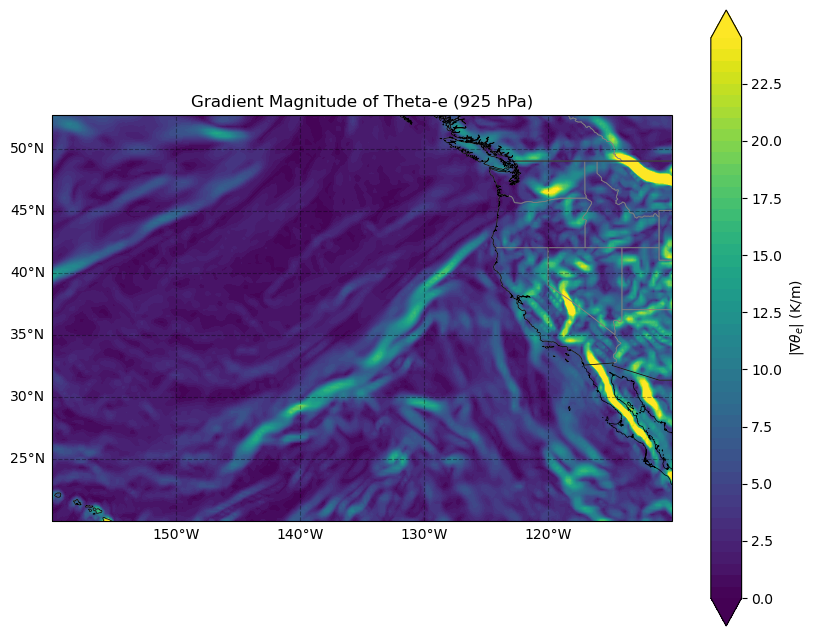

In [25]:
# Calculate the magnitude of the gradient
gradient_magnitude = np.sqrt(dtheta_e_dx**2 + dtheta_e_dy**2)

# Define the map projection and the extent of the plot
projection = ccrs.PlateCarree()
extent = [directions['West'], directions['East'], directions['South'], directions['North']]

# Plot the gradient magnitude
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the gradient magnitude using contourf
magnitude_contour = ax.contourf(longitudes, latitudes, gradient_magnitude, levels=np.arange(0, 25, 0.5), cmap='viridis', extend='both')
cbar = fig.colorbar(magnitude_contour, ax=ax, orientation='vertical', label=r"$|\nabla \theta_e|$ (K/m)")
ax.set_title("Gradient Magnitude of Theta-e (925 hPa)")

plt.show()

In [40]:
km_per_degree_lat = 111  # Approximate conversion factor for latitude (in km per degree)
dtheta_e_dy_km = dtheta_e_dy * km_per_degree_lat

# For longitude, account for the cosine of the latitude
km_per_degree_lon = 111 * np.cos(np.radians(latitudes))  # Distance per degree longitude varies by latitude

# Reshape km_per_degree_lon to match the shape of dtheta_e_dx
km_per_degree_lon = km_per_degree_lon[:, np.newaxis]  # Add a new axis to make it (141, 1)

# Now multiply
dtheta_e_dx_km = dtheta_e_dx * km_per_degree_lon

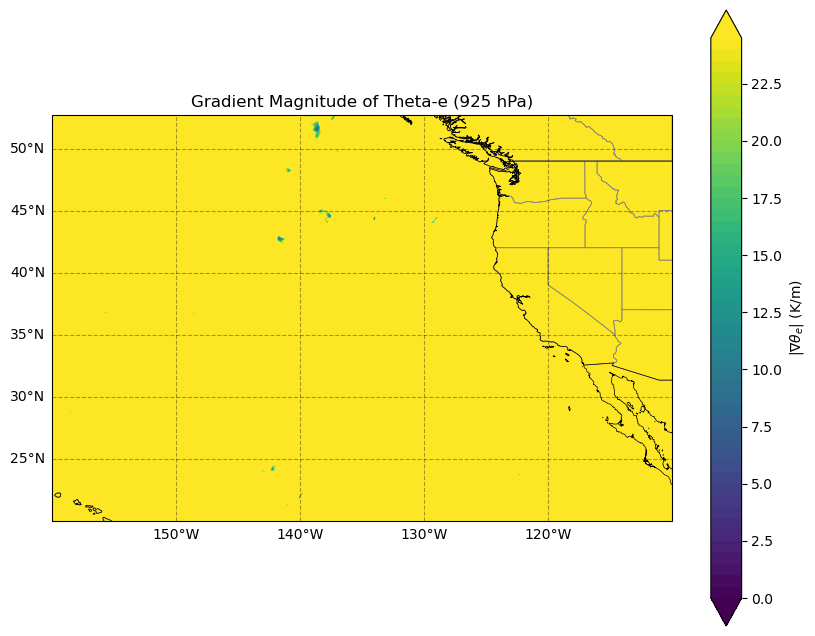

In [41]:
# Calculate the magnitude of the gradient
gradient_magnitude = np.sqrt(dtheta_e_dy_km**2 + dtheta_e_dx_km**2)

# Define the map projection and the extent of the plot
projection = ccrs.PlateCarree()
extent = [directions['West'], directions['East'], directions['South'], directions['North']]

# Plot the gradient magnitude
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the gradient magnitude using contourf
magnitude_contour = ax.contourf(longitudes, latitudes, gradient_magnitude, levels=np.arange(0, 25, 0.5), cmap='viridis', extend='both')
cbar = fig.colorbar(magnitude_contour, ax=ax, orientation='vertical', label=r"$|\nabla \theta_e|$ (K/m)")
ax.set_title("Gradient Magnitude of Theta-e (925 hPa)")

plt.show()

In [43]:
import metpy.xarray

In [44]:
dx, dy = mpcalc.gradient(theta_e_925)

# Use grid_deltas_from_dataarray to get the actual distances between grid points
dx_actual, dy_actual = metpy.xarray.grid_deltas_from_dataarray(theta_e_925, kind="actual")

# Now you can calculate the gradient in K/km
dtheta_e_dy_km = dy / dy_actual  # Gradient in K/km for latitude
dtheta_e_dx_km = dx / dx_actual

ValueError: operands could not be broadcast together with shapes (141,201) (140,201) 

In [35]:
dtheta_e_dy, dtheta_e_dx = mpcalc.gradient(theta_e_925, coordinates=(latitudes, longitudes))

# Conversion factor for latitude (in meters per degree)
lat_conversion = 111320 * units.meter  # meters per degree of latitude

# For longitude, adjust by the cosine of the latitude and convert to meters
lon_conversion = (111320 * np.cos(np.radians(latitudes)) * units.meter)  # meters per degree of longitude

# Ensure lon_conversion is broadcastable by reshaping it to match the shape of dtheta_e_dx
lon_conversion_broadcasted = np.expand_dims(lon_conversion, axis=-1)  # Shape (141, 1)

# Convert the gradients to K/m
dtheta_e_dy_m = dtheta_e_dy * lat_conversion  # K/m for latitude gradient
dtheta_e_dx_m = dtheta_e_dx * lon_conversion_broadcasted  # K/m for longitude gradient

# Convert to K/km by dividing by 1000
dtheta_e_dy_km = dtheta_e_dy_m / 1000  # K/km
dtheta_e_dx_km = dtheta_e_dx_m / 1000  # K/km

# Check the units of the resulting gradients
print(dtheta_e_dy_m.units)
print(dtheta_e_dx_m.units)

kelvin * meter / degree
kelvin * meter / degree


In [34]:
dtheta_e_dy, dtheta_e_dx = mpcalc.gradient(theta_e_925, coordinates=(latitudes, longitudes))

# Conversion factor for latitude (in meters per degree)
lat_conversion = 111320 * units.meter  # meters per degree of latitude

# For longitude, adjust by the cosine of the latitude and convert to meters
lon_conversion = (111320 * np.cos(np.radians(latitudes)) * units.meter)  # meters per degree of longitude

# Ensure lon_conversion is broadcastable by reshaping it to match the shape of dtheta_e_dx
lon_conversion_broadcasted = np.expand_dims(lon_conversion, axis=-1)  # Shape (141, 1)

# Convert the gradients to K/m
dtheta_e_dy_m = dtheta_e_dy * lat_conversion  # K/m for latitude gradient
dtheta_e_dx_m = dtheta_e_dx * lon_conversion_broadcasted  # K/m for longitude gradient

# Convert to K/km by dividing by 1000
dtheta_e_dy_km = dtheta_e_dy_m / 1000  # K/km
dtheta_e_dx_km = dtheta_e_dx_m / 1000  # K/km

# Check the units of the resulting gradients
print(dtheta_e_dy_m.units)
print(dtheta_e_dx_m.units)

kelvin * meter / degree
kelvin * meter / degree


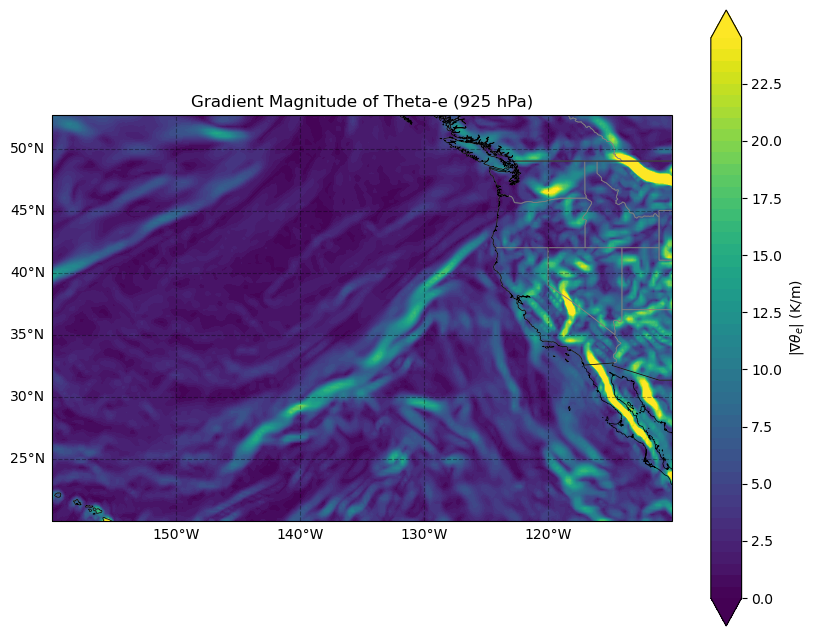

In [28]:
# Calculate the magnitude of the gradient
gradient_magnitude = np.sqrt(dtheta_e_dx**2 + dtheta_e_dy**2)

# Define the map projection and the extent of the plot
projection = ccrs.PlateCarree()
extent = [directions['West'], directions['East'], directions['South'], directions['North']]

# Plot the gradient magnitude
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color='white')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='#fbf5e9')

# Add gridlines and format longitude/latitude labels
gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
gls.top_labels = False
gls.right_labels = False
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the gradient magnitude using contourf
magnitude_contour = ax.contourf(longitudes, latitudes, gradient_magnitude, levels=np.arange(0, 25, 0.5), cmap='viridis', extend='both')
cbar = fig.colorbar(magnitude_contour, ax=ax, orientation='vertical', label=r"$|\nabla \theta_e|$ (K/m)")
ax.set_title("Gradient Magnitude of Theta-e (925 hPa)")

plt.show()